In [41]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import newton

from utils import *

from ipywidgets import interact

import torch
from torch import nn
import torch.nn.functional as F

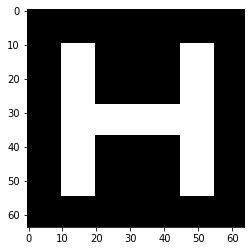

In [42]:
spread = [10,10]
size = 64
shape = (size, size)
pixels = shape[0] * shape[1]

x_true = build_x_true().reshape(-1,1)

plt.imshow(im(x_true, shape), cmap='Greys_r')

In [43]:
Q,H = arnoldi(x_true.reshape(shape)+1, n=5, q_0 = x_true.reshape(shape)[:,0].reshape(-1,1)+1)

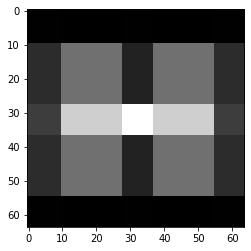

In [44]:
plt.imshow( (Q @ H @ Q[:,:-1].T) , cmap='Greys_r')

In [45]:
(H @ Q[:,:-1].T).shape

(6, 64)

In [46]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, rows, cols, n_factors=10):
        super().__init__()
        self.row_embedding = torch.nn.parameter.Parameter(torch.rand(rows, n_factors), requires_grad=True)
        self.col_embedding = torch.nn.parameter.Parameter(torch.rand(n_factors, cols), requires_grad=True)

    def forward(self):
        return torch.matmul( self.row_embedding, self.col_embedding )

In [47]:
device = torch.device('cuda:0')

In [48]:
mf = MatrixFactorization(64, 64, 10).to(device=device)

In [49]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(mf.parameters(), lr=0.001)

In [50]:
im_true = torch.Tensor(x_true.reshape(shape)).to(device=device)

In [51]:
for epoch in range(1000):
    
    optimizer.zero_grad()

    output = mf.forward()
    loss = criterion(output,im_true)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(loss)

tensor(5.5206, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5045, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3027, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7738, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3709, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2851, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2287, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1886, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1583, device='cuda:0', grad_fn=<MseLossBackward0>)


In [52]:
torch.linalg.norm((mf.row_embedding @ mf.col_embedding) - im_true)

tensor(23.4853, device='cuda:0', grad_fn=<CopyBackwards>)

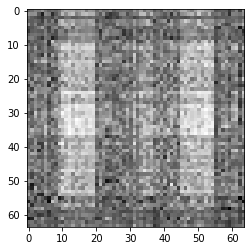

In [53]:
plt.imshow( (mf.row_embedding @ mf.col_embedding).cpu().detach().numpy() , cmap='Greys_r')

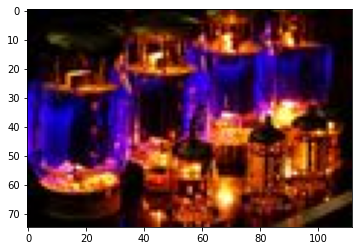

In [54]:
from matplotlib.image import imread

data = imread('../data/vacuum_tubes.jpg')
im_true = torch.Tensor(data/data.max())

plt.imshow(im_true.detach().numpy())

In [55]:
rows = np.arange(75)
cols = np.arange(112)
ROWS, COLS = np.meshgrid(rows,cols)
coords = np.hstack([ROWS.reshape(-1,1), COLS.reshape(-1,1) ])

coords.shape

(8400, 2)

In [56]:
distances = np.zeros(shape=(8400,8400))

for ii in range(8400):
    
    distances[:,ii] = np.linalg.norm(coords - np.tile(coords[ii,:], (8400,1) ) , axis=1)

adjacency = np.int32( distances <= 2 )

In [67]:
laplacian = np.diag( np.sum(adjacency, axis=0).flatten() ) - adjacency
laplacian_tensor = torch.Tensor(laplacian).to(device=device)

In [58]:
im_true_flat = im_true.reshape(75*112, 3).to(device=device)

In [59]:
mf = MatrixFactorization(75*112, 3, 40).to(device=device)

In [60]:
import torch.optim as optim

criterion = nn.MSELoss()

def laplacian_loss(X):
    added_dims = torch.unsqueeze(torch.unsqueeze(X,dim=0),dim=0)
    laplacian_kernel = torch.Tensor([[ [[0.,-1.,0.],[-1.,2.,-1.],[0.,-1.,0.]] ]])

    return F.conv2d(added_dims, laplacian_kernel).pow(2).sum()

def laplacian_loss_matrix(X, laplacian):

    return torch.diag(X.T @ laplacian @ X).sum()
    
optimizer = optim.Adam(mf.parameters(), lr=0.001)

In [61]:
for epoch in range(10000):
    
    optimizer.zero_grad()

    output = mf.forward()
    loss = criterion(output, im_true_flat) #+ 0.00001*laplacian_loss_matrix(output, laplacian_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(loss)

tensor(102.4145, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.9578, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2544, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3830e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.1319e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2519e-08, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1514e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.8237e-12, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1216e-12, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0135e-12, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.2337e-13, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7896e-13, device='cuda:0', grad_fn=<MseLossBackward0>)
te

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


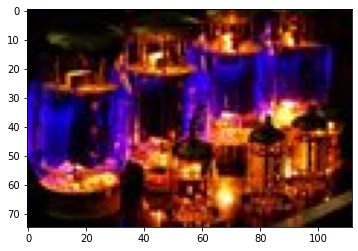

In [62]:
plt.imshow(output.reshape(75,112,3).cpu().detach().numpy())

In [63]:
torch.linalg.norm((mf.row_embedding @ mf.col_embedding) - im_true_flat)

tensor(1.9189e-05, device='cuda:0', grad_fn=<CopyBackwards>)

In [64]:
class MatrixFactorization_2(torch.nn.Module):
    def __init__(self, n_samples, n_genes, n_factors=20):
        super().__init__()

        # weights
        self.sample_factors = torch.nn.Embedding(n_samples, n_factors, sparse=False)
        self.gene_factors = torch.nn.Embedding(n_genes, n_factors, sparse=False)

        # biases
        self.sample_biases = torch.nn.Embedding(n_samples, 1, sparse=False)
        self.gene_biases = torch.nn.Embedding(n_genes, 1, sparse=False)

    def forward(self, sample, gene):
        return (self.sample_factors(sample) * self.gene_factors(gene)).sum(1) + (self.sample_biases(sample) + self.gene_biases(gene)).sum(1)

In [65]:
model = MatrixFactorization_2(75*112, 3, 3).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [96]:
for ii in range(10000): # for batch in batches
    # Set gradients to zero
    optimizer.zero_grad()

    # Predict and calculate loss
    prediction = model(im_true_flat.nonzero()[:,0], im_true_flat.nonzero()[:,1])
    reshaped = torch.zeros(size=im_true_flat.shape).to(device=device)
    reshaped[ im_true_flat.nonzero(as_tuple=True) ] = prediction.flatten()
    loss = criterion(prediction, im_true_flat[ im_true_flat.nonzero(as_tuple=True) ]) + 0.000001 * torch.diag(reshaped.T @ laplacian_tensor @ reshaped).sum()

    # Backpropagate
    loss.backward() 

    # Update the parameters
    optimizer.step()

    if ii % 500 == 0:
      print(loss)

tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<AddBack

In [97]:
prediction.shape

torch.Size([20567])

In [98]:
im_true_flat.nonzero().shape

torch.Size([20567, 2])

In [99]:
ii

9999

In [100]:
reshaped.shape

torch.Size([8400, 3])

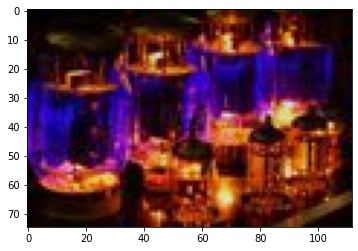

In [101]:
plt.imshow(reshaped.reshape(75,112,3).cpu().detach().numpy())